# Classification of MNIST

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix

import skimage.io as io
from skimage.transform import rotate

import matplotlib.pyplot as plt
import numpy as np
import glob
import imageio
import zipfile

plt.style.use('ggplot')

In [ ]:
drive_folder = '/content/drive/MyDrive'
folder = drive_folder + '/A3_DL4IA/Ex1'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Functions needed in this notebook

In [ ]:
def extract_files(file_name):
    """Extract the input zip file in the current directory."""
    
    with zipfile.ZipFile(file_name, 'r') as zip:
        zip.extractall()

In [ ]:
def load_mnist(reshape):
    """Loads the MNIST dataset from png images.
    
    Args:
        reshape (bool): if True, reshape images into 784 vectors, otherwise keep the original image shape 28x28
        
    Returns:
        X_train (numpy array): train images, shape (60000, 784) if reshape=True, (60000, 28, 28) otherwise
        Y_train (numpy array): train labels, shape (60000, )
        X_test (numpy array): test images, shape (10000, 784) if reshape=True, (10000, 28, 28) otherwise
        Y_test (numpy array): test labels, shape (10000, )
    """
    
    NUM_LABELS = 10  
    
    # Load train set 
    train_images = []
    train_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Train/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            train_images.append(image)
            train_labels.append(label)    
            
    # Load test set
    test_images = []
    test_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Test/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            test_images.append(image)
            test_labels.append(label)  
           
    if reshape:
        X_train = np.array(train_images).reshape(-1,784)/255.0
        X_test = np.array(test_images).reshape(-1,784)/255.0
    else:
        X_train = np.array(train_images)/ 255.0
        X_test = np.array(test_images)/255.0

    Y_train = np.array(train_labels)
    Y_test = np.array(test_labels)
    
    return X_train, Y_train, X_test, Y_test

In [ ]:
class MyMNISTDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
def compute_accuracy(output, Y_true):
    """Computes the accuracy based on the provided output of the network the true labels.
    
    Args:
        output (tensor): linear output of the CNN
        Y_true (tensor): the labels
    """
    predictions = nn.Softmax(dim=1)(output)
    Y_pred = torch.argmax(predictions, dim=1)
    accuracy = (Y_pred == Y_true).float().mean()
    return accuracy

In [ ]:
def train_model(model, loss_criterion, performance_metric, optimizer, train_loader, X_test, Y_test, num_epochs, is_L1=False, plot_result=False):
  train_losses = list()
  train_scores = list()
  test_losses = list()
  test_scores = list()

  for epoch in range(num_epochs):
      train_losses_epoch = list()
      train_scores_epoch = list()

      for batch in train_loader:
          x_train, y_train = batch[0].to(device), batch[1].to(device)
          
          model.zero_grad()

          # 1. Forward propagation
          output = model(x_train)

          # 2. Compute loss and score on current mini-batch
          loss = loss_criterion(output, y_train)

          train_loss = loss.item()
          train_losses_epoch.append(train_loss)
          train_score = performance_metric(output, y_train).item()
          train_scores_epoch.append(train_score)

          # 3. Backpropagation
          if is_L1:
            regularization_term = 0
            for param in model.parameters():
                regularization_term += torch.sum(abs(param))
             
            loss = loss + 0.001 * regularization_term
          loss.backward()  

          # 4. Update parameters
          optimizer.step()
      
      # Train cost and score 
      train_loss = np.mean(train_losses_epoch)
      train_losses.append(train_loss)
      train_score = np.mean(train_scores_epoch)
      train_scores.append(train_score)

      # Test cost and score
      with torch.no_grad():
          output = model(X_test)

          test_loss = loss_criterion(output, Y_test).item()
          test_losses.append(test_loss)
          test_score = performance_metric(output, Y_test).item()
          test_scores.append(test_score)
      
      if plot_result and epoch % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"  loss: {train_loss:.4f}, score: {train_score:.4f}")
        print(f"  test_loss: {test_loss:.4f}, test_score: {test_score:.4f}\n")

        
  print("FINAL")
  print(f'  loss: {train_loss:.4f}, score: {train_score:.4f}')
  print(f'  test_loss: {test_loss:.4f}, test_score: {test_score:.4f}')

  return train_losses, train_scores, test_losses, test_scores

In [ ]:
def plot_result(metric, train_res, test_res, model_name, learning_rate, num_epochs, optim="sgd", batch_size=32, save_folder=None):
    x_axis = range(num_epochs)
    plt.figure(figsize=(12,7))
    plt.plot(x_axis, test_res, label="Test data", zorder=10)
    plt.plot(x_axis, train_res, label="Training data", zorder=0)
    plt.ylabel(metric)
    plt.xlabel("Epochs")
    plt.title(f"{model_name} {metric} over {num_epochs} epochs")
    plt.legend()
    if save_folder:
      plt.savefig(f'{save_folder}/{model_name}_{metric}_{train_res[-1]:.4f}_test_{metric}_{test_res[-1]:.4f}_ep_{num_epochs}_{optim}_lr_{learning_rate}_bs_{batch_size}.png')

In [ ]:
extract_files(drive_folder + "/MNIST.zip")

## Exercise 1.1 - FNN
We design the same (fully connected) network as we did for
Assignment 2 using built-in PyTorch functions.

In [ ]:
INPUT_SIZE = 784
HIDDEN_SIZE = 800 # Number of nodes at the hidden layer
NUM_CLASSES = 10
NUM_EPOCHS = 30
BATCH_SIZE = 1024
LEARNING_RATE = 1

### Load the dataset (reshape = True)
We first load the MNIST dataset into numpy arrays. Then create torch train and test datasets with custom `MyMNISTDataset` class, inherited from `torch.utils.data.Dataset` class. Only a data loader is created for the train set. The whole test data is transformed into tensors and moved to GPU in `X_test` and `Y_test` if available.

In [ ]:
# Split MNIST dataset into training and test set
X_train_numpy, Y_train_numpy, X_test_numpy, Y_test_numpy = load_mnist(reshape=True)

In [ ]:
# Create train loader (all variables are tensors now)
train_set = MyMNISTDataset(X_train_numpy, Y_train_numpy)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Create train set (all variables are tensors now)
test_set = MyMNISTDataset(X_test_numpy, Y_test_numpy)
X_test, Y_test = test_set[:]
X_test = X_test.to(device)
Y_test = Y_test.to(device)

### Create and train the FNN  

In [ ]:
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
      super(FNN, self).__init__()
      self.fc1 = nn.Linear(input_size, hidden_size)
      self.relu = nn.ReLU()
      self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      return x

In [ ]:
# Instantiate the model
fnn = FNN(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES).to(device)

# Define loss and optimizer
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(fnn.parameters(), lr=LEARNING_RATE)

In [ ]:
# Train the model
train_losses, train_accuracies, test_losses, test_accuracies = train_model(fnn, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=NUM_EPOCHS)

FINAL
  loss: 0.0188, acc: 0.9972
  test_loss: 0.0589, test_acc: 0.9805


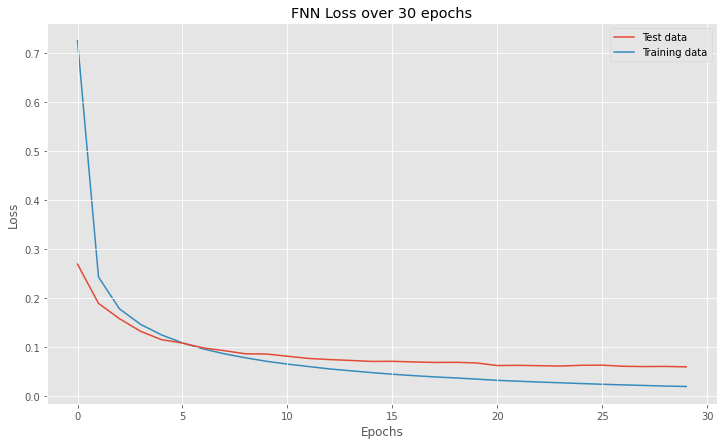

In [ ]:
# Plot train and test loss
x_axis = range(NUM_EPOCHS)
plt.figure(figsize=(12,7))
plt.plot(x_axis, test_losses, label="Test data", zorder=10)
plt.plot(x_axis, train_losses, label="Training data", zorder=0)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("FNN Loss over 30 epochs")
plt.legend()
plt.savefig(f"{folder}/FNN_loss_{train_losses[-1]:.4f}_test_loss_{test_losses[-1]:.4f}_ep_30_sgd_lr_1_bs_1024.png")

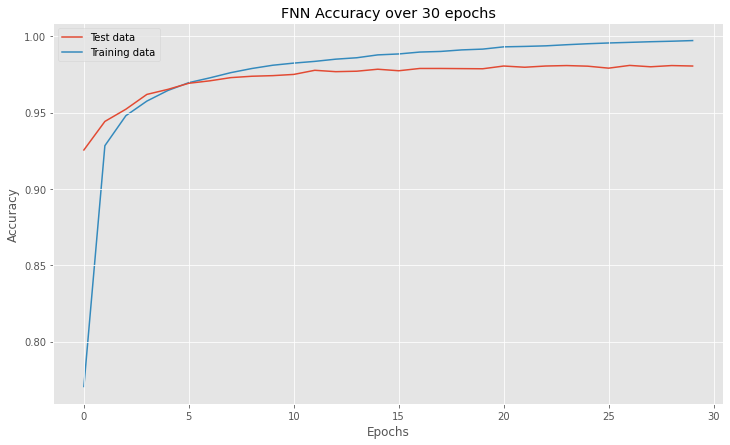

In [ ]:
# Plot train and test accuracy
x_axis = range(NUM_EPOCHS)
plt.figure(figsize=(12,7))
plt.plot(x_axis, test_accuracies, label="Test data", zorder=10)
plt.plot(x_axis, train_accuracies, label="Training data", zorder=0)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("FNN Accuracy over 30 epochs")
plt.legend()
plt.savefig(f"{folder}/FNN_acc_{train_accuracies[-1]:.4f}_test_acc_{test_accuracies[-1]:.4f}_ep_30_sgd_lr_1_bs_1024.png")

## Exercise 1.2 - CNN
We now build a Convolutional Neural Network (CNN). The model will be trained using Stochastic Gradient Descent (SGD).

In [ ]:
INPUT_SIZE = (1, 28, 28)
NUM_CLASSES = 10
NUM_EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.1

### Load the dataset (reshape = False)

In [ ]:
# Split MNIST dataset into training and test set
X_train_numpy, Y_train_numpy, X_test_numpy, Y_test_numpy = load_mnist(reshape=False)

In [ ]:
print(X_train_numpy.shape, Y_train_numpy.shape, X_test_numpy.shape, Y_test_numpy.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [ ]:
# In PyTorch: [batch_size, channel, height, width]
X_train_numpy = X_train_numpy.reshape(60000, 1, 28, 28)
X_test_numpy = X_test_numpy.reshape(10000, 1, 28, 28)

# Create train loader (all variables are tensors now)
train_set = MyMNISTDataset(X_train_numpy, Y_train_numpy)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# Create train set (all variables are tensors now)
test_set = MyMNISTDataset(X_test_numpy, Y_test_numpy)
X_test, Y_test = test_set[:]
X_test = X_test.to(device)
Y_test = Y_test.to(device)

### Create and train the CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
      super(CNN, self).__init__()

      self.model = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1), # output: 8x28x28 (c,w,h)
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2), # output: 8x14x14
          nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), # output: 16x14x14
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2), # output: 16x7x7
          nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # output: 32x7x7
          nn.ReLU() 
      )

      self.classifier = nn.Sequential(
          nn.Linear(32*7*7, 10)
      )

    def forward(self, x):
      x = self.model(x)
      x = self.classifier(x.view(x.size(0), -1))
      return x

In [ ]:
# Instantiate the model
cnn = CNN().to(device)

# Define loss and optimizer
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(cnn.parameters(), lr=LEARNING_RATE)

In [ ]:
# Train the model (2min40)
train_losses, train_accuracies, test_losses, test_accuracies = train_model(fnn, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=NUM_EPOCHS)

FINAL
  loss: 0.0056, acc: 0.9981
  test_loss: 0.0419, test_acc: 0.9902


In [ ]:
# Save model 
model_name = "CNN_1-2"
torch.save({
            'epoch': 20,
            'model_state_dict': cnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_losses[-1],
            'acc': train_accuracies[-1],
            'test_loss': test_losses[-1],
            'test_acc': test_accuracies[-1]
            }, f"{folder}/models/{model_name}")

### Results

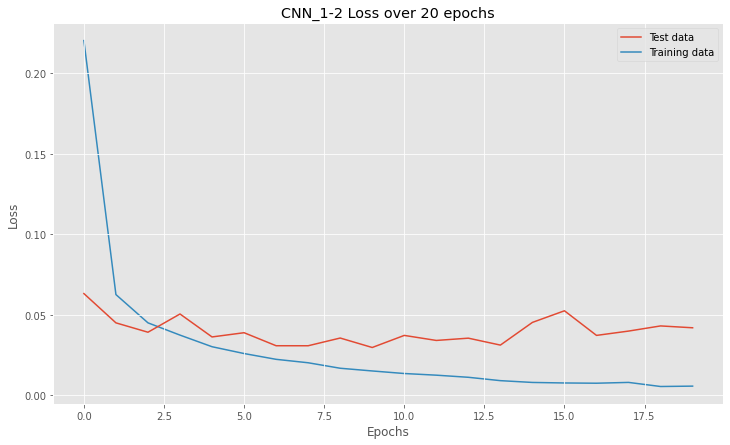

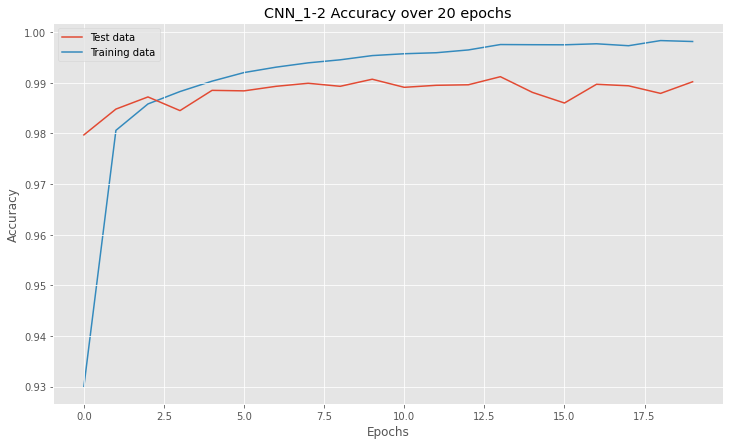

In [ ]:
plot_result("Loss", train_losses, test_losses, model_name, LEARNING_RATE, NUM_EPOCHS, save_folder=folder)
plot_result("Accuracy", train_accuracies, test_accuracies, model_name, LEARNING_RATE, NUM_EPOCHS, save_folder=folder)

## Exercise 1.3 - Exchanging Pooling and ReLU
We want to know what would change (accuracy, speed) if we swap the order of the Pooling and ReLU operations. We also replace ReLU with Tanh activation function.

### With ReLU

#### Create and train the CNN

In [ ]:
class CNN_POOL_RELU(nn.Module):
    def __init__(self):
      super(CNN_POOL_RELU, self).__init__()

      self.model = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1), # output: 8x28x28 (c,w,h)
          nn.MaxPool2d(kernel_size=2, stride=2), # output: 8x14x14
          nn.ReLU(),
          nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), # output: 16x14x14
          nn.MaxPool2d(kernel_size=2, stride=2), # output: 16x7x7
          nn.ReLU(),
          nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # output: 32x7x7
          nn.ReLU() 
      )

      self.classifier = nn.Sequential(
          nn.Linear(32*7*7, 10)
      )

    def forward(self, x):
      x = self.model(x)
      x = self.classifier(x.view(x.size(0), -1))
      return x

In [ ]:
# Instantiate the model
cnn = CNN_POOL_RELU().to(device)

# Define loss and optimizer
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(cnn.parameters(), lr=LEARNING_RATE)

In [ ]:
# Train the model (6min41)
train_losses, train_accuracies, test_losses, test_accuracies = train_model(fnn, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=50)

FINAL
  loss: 0.0000, acc: 1.0000
  test_loss: 0.0540, test_acc: 0.9908


In [ ]:
# Save model 
model_name = "CNN_1-3_Pool_Relu"
torch.save({
            'epoch': 50,
            'model_state_dict': cnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_losses[-1],
            'acc': train_accuracies[-1],
            'test_loss': test_losses[-1],
            'test_acc': test_accuracies[-1]
            }, f"{folder}/models/{model_name}_ep_50")

#### Results

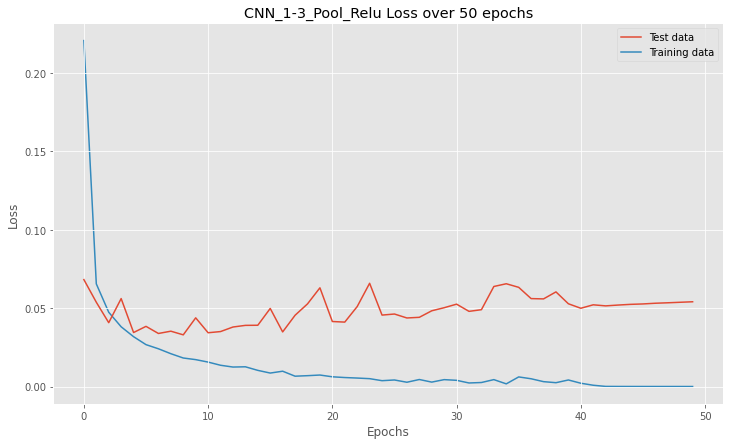

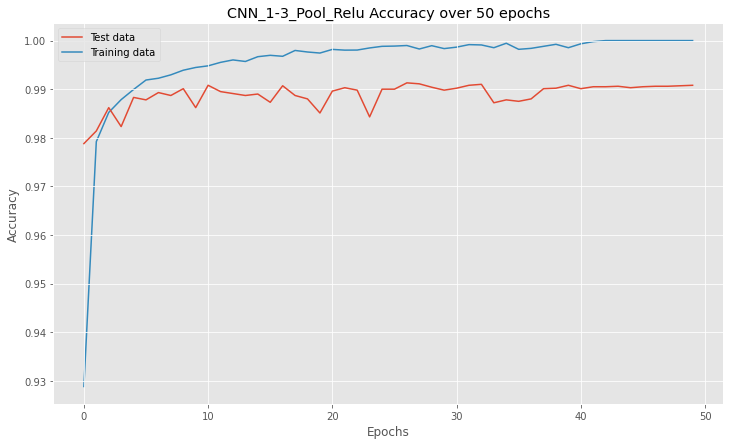

In [ ]:
plot_result("Loss", train_losses, test_losses, model_name, LEARNING_RATE, 50, save_folder=folder)
plot_result("Accuracy", train_accuracies, test_accuracies, model_name, LEARNING_RATE, 50, save_folder=folder)

### With Tanh

#### Create and train the CNN

In [ ]:
class CNN_POOL_TANH(nn.Module):
    def __init__(self):
      super(CNN_POOL_TANH, self).__init__()

      self.model = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1), # output: 8x28x28 (c,w,h)
          nn.MaxPool2d(kernel_size=2, stride=2), # output: 8x14x14
          nn.Tanh(),
          nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), # output: 16x14x14
          nn.MaxPool2d(kernel_size=2, stride=2), # output: 16x7x7
          nn.Tanh(),
          nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # output: 32x7x7
          nn.Tanh()
      )

      self.classifier = nn.Sequential(
          nn.Linear(32*7*7, 10)
      )

    def forward(self, x):
      x = self.model(x)
      x = self.classifier(x.view(x.size(0), -1))
      return x

In [ ]:
# Instantiate the model
cnn = CNN_POOL_TANH().to(device)

# Define loss and optimizer
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(cnn.parameters(), lr=LEARNING_RATE)

In [ ]:
# Train the model (6min35)
train_losses, train_accuracies, test_losses, test_accuracies = train_model(fnn, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=50)

FINAL
  loss: 0.0007, acc: 1.0000
  test_loss: 0.0336, test_acc: 0.9907


In [ ]:
# Save model 
model_name = "CNN_1-3_Pool_Tanh"
torch.save({
            'epoch': 50,
            'model_state_dict': cnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_losses[-1],
            'acc': train_accuracies[-1],
            'test_loss': test_losses[-1],
            'test_acc': test_accuracies[-1]
            }, f"{folder}/models/{model_name}_ep_50")

#### Results

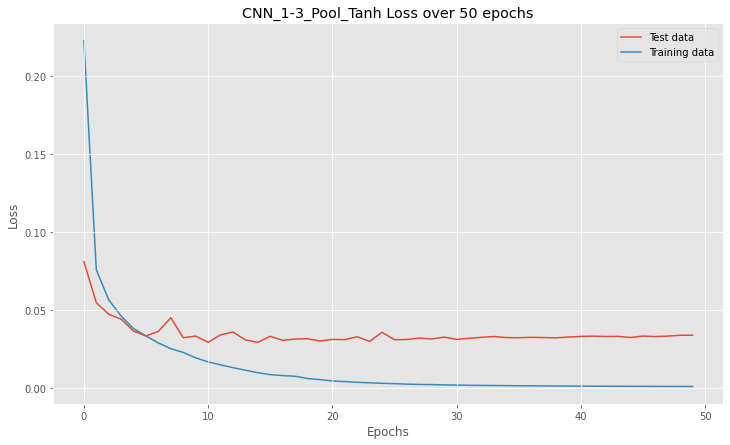

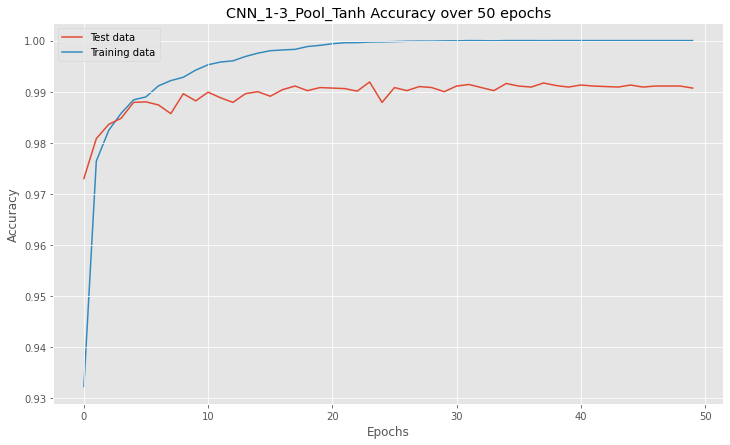

In [ ]:
plot_result("Loss", train_losses, test_losses, model_name, LEARNING_RATE, 50, save_folder=folder)
plot_result("Accuracy", train_accuracies, test_accuracies, model_name, LEARNING_RATE, 50, save_folder=folder)

## Exercice 1.4 - Adam

In [ ]:
# Instantiate the model
cnn = CNN().to(device)

# Define loss and optimizer
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [ ]:
# Train the model (2min53)
train_losses, train_accuracies, test_losses, test_accuracies = train_model(fnn, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=50)

FINAL
  loss: 0.0050, acc: 0.9983
  test_loss: 0.0502, test_acc: 0.9906


In [ ]:
# Save model 
model_name = "CNN_1-4_Adam"
torch.save({
            'epoch': 20,
            'model_state_dict': cnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_losses[-1],
            'acc': train_accuracies[-1],
            'test_loss': test_losses[-1],
            'test_acc': test_accuracies[-1]
            }, f"{folder}/models/{model_name}")

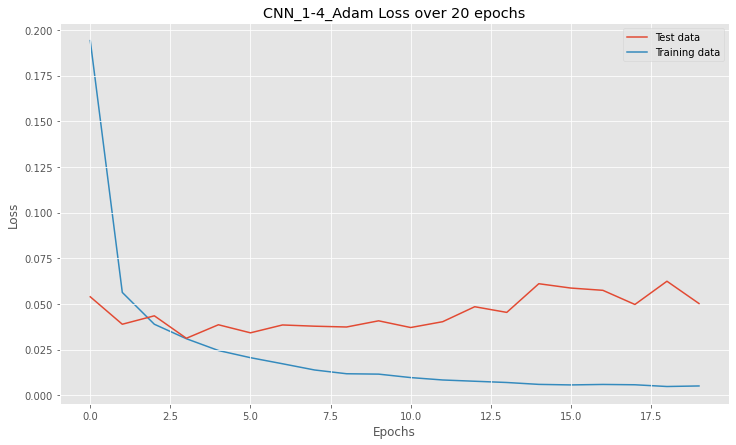

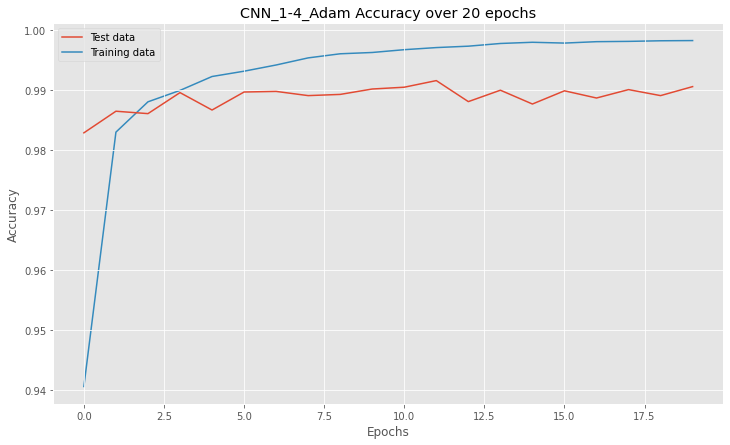

In [ ]:
plot_result("Loss", train_losses, test_losses, model_name, LEARNING_RATE, NUM_EPOCHS, save_folder=folder)
plot_result("Accuracy", train_accuracies, test_accuracies, model_name, LEARNING_RATE, NUM_EPOCHS, save_folder=folder)

## Exercise 1.5 - Variations
We try a few variations to improve performance.


#### 1. How many convolution-activation-pool block?

In [ ]:
class CNN_block(nn.Module):
    def __init__(self, num_blocks):
      super(CNN_block, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1) # output: 8x28x28 (c,w,h)
      self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1) # output after pool2: 16x14x14
      self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # output after pool2: 32x7x7
      self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # output after pool1: 64x6x6

      self.relu = nn.ReLU()
      self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
      self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

      if num_blocks == 1:
        self.model = nn.Sequential(
            self.conv1,
            self.relu
        )
        output_size = 8*28*28
      elif num_blocks == 2:
        self.model = nn.Sequential(
            self.conv1,
            self.relu,
            self.pool2,
            self.conv2,
            self.relu
        )
        output_size = 16*14*14
      elif num_blocks == 3:
        self.model = nn.Sequential(
            self.conv1,
            self.relu,
            self.pool2,
            self.conv2,
            self.relu,
            self.pool2,
            self.conv3,
            self.relu
        )
        output_size = 32*7*7
      elif num_blocks == 4:
        self.model = nn.Sequential(
            self.conv1,
            self.relu,
            self.pool2,
            self.conv2,
            self.relu,
            self.pool2,
            self.conv3,
            self.relu,
            self.pool1,
            self.conv4,
            self.relu
        )
        output_size = 64*6*6
      else:
        raise ValueError("Number of convolution layers between 1 and 4.")

      self.classifier = nn.Sequential(
          nn.Linear(output_size, 10)
      )

    def forward(self, x):
      x = self.model(x)
      x = self.classifier(x.view(x.size(0), -1))
      return x

In [ ]:
models_block = []
all_train_losses, all_train_accuracies, all_test_losses, all_test_accuracies = [], [], [], []

blocks = [1, 2, 3, 4]
for num_blocks in blocks:
  print(f"\nCNN with {num_blocks} conv block(s)")

  cnn = CNN_block(num_blocks).to(device)

  # Define loss and optimizer
  loss_criterion = nn.CrossEntropyLoss().to(device)
  optimizer = optim.Adam(cnn.parameters(), lr=0.001)

  train_losses, train_accuracies, test_losses, test_accuracies = train_model(fnn, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=20)
  all_train_losses.append(train_losses)
  all_train_accuracies.append(train_accuracies)
  all_test_losses.append(test_losses)
  all_test_accuracies.append(test_accuracies)
  models_block.append(cnn)


CNN with 1 conv block(s)
FINAL
  loss: 1.4706, acc: 0.9913
  test_loss: 1.4826, test_acc: 0.9793

CNN with 2 conv block(s)
FINAL
  loss: 1.4683, acc: 0.9931
  test_loss: 1.4745, test_acc: 0.9866

CNN with 3 conv block(s)
FINAL
  loss: 1.4683, acc: 0.9929
  test_loss: 1.4724, test_acc: 0.9885

CNN with 4 conv block(s)
FINAL
  loss: 1.4774, acc: 0.9837
  test_loss: 1.4774, test_acc: 0.9838


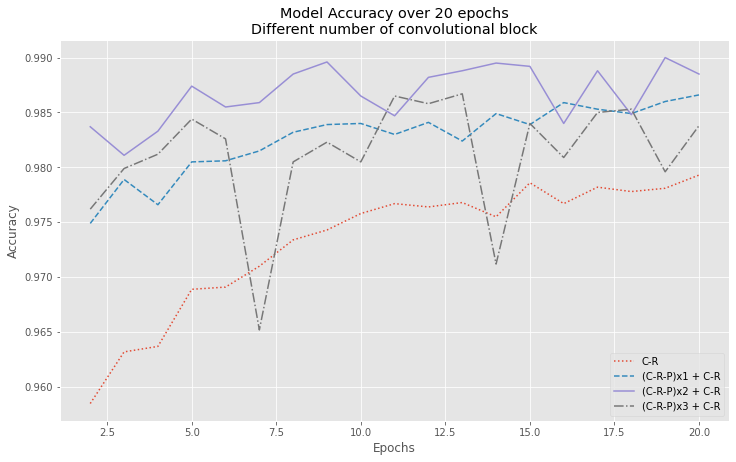

In [ ]:
linestyles = [':', '--', '-', '-.']
plt.figure(figsize=(12,7))

for i in range(4):
  model_name = f"(C-R-P)x{i} + C-R" if i != 0 else "C-R"
  plt.plot(range(2, NUM_EPOCHS + 1), np.squeeze(all_test_accuracies[i][1:]), label=model_name, linestyle=linestyles[i])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over 20 epochs\nDifferent number of convolutional block')
plt.legend()
plt.savefig(f'{folder}/Acc_num_conv_ep_20_Adam_lr_0.001_bs_32_act_Relu.png')

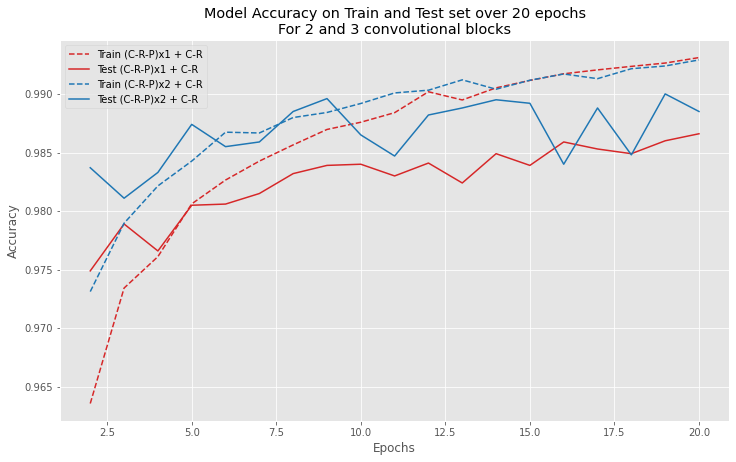

In [ ]:
plt.figure(figsize=(12,7))

names = ["(C-R-P)x1 + C-R", "(C-R-P)x2 + C-R"]
x_axis = range(2, NUM_EPOCHS + 1)
plt.plot(x_axis, np.squeeze(all_train_accuracies[1][1:]), "--", color="tab:red", label="Train " + names[0])
plt.plot(x_axis, np.squeeze(all_test_accuracies[1][1:]), color="tab:red", label="Test " + names[0])
plt.plot(x_axis, np.squeeze(all_train_accuracies[2][1:]), "--", color="tab:blue", label="Train " + names[1])
plt.plot(x_axis, np.squeeze(all_test_accuracies[2][1:]), color="tab:blue", label="Test " + names[1])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Train and Test set over 20 epochs\nFor 2 and 3 convolutional blocks')
plt.legend()
plt.savefig(f'{folder}/Acc_num_conv_2-3_ep_20_Adam_lr_0.001_bs_32_act_Relu.png')

Conclusion: Model with 3 convolutional blocks performs better on test set and also less overfit.

CNN with 2 conv block(s)
FINAL
  loss: 1.4683, acc: 0.9931
  test_loss: 1.4745, test_acc: 0.9866

CNN with 3 conv block(s)
FINAL
  loss: 1.4683, acc: 0.9929
  test_loss: 1.4724, test_acc: 0.9885

#### 2. How many feature maps?

In [ ]:
class CNN_feature_maps(nn.Module):
    def __init__(self, num_feature_maps):
      super(CNN_feature_maps, self).__init__()
      self.num_feature_maps = num_feature_maps
      self.model = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=num_feature_maps, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2), 
          nn.Conv2d(num_feature_maps, num_feature_maps*2, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(num_feature_maps*2, num_feature_maps*4, kernel_size=3, stride=1, padding=1),
          nn.ReLU() 
      )

      self.classifier = nn.Sequential(
          nn.Linear(num_feature_maps*4*7*7, 10)
      )

    def forward(self, x):
      x = self.model(x)
      x = self.classifier(x.view(x.size(0), -1))
      return x

In [ ]:
models_feature_maps = []
all_train_losses, all_train_accuracies, all_test_losses, all_test_accuracies = [], [], [], []

feature_maps = [8, 16, 32, 64]
for num_feature_maps in feature_maps:
  print(f"\nCNN with {num_feature_maps} feature maps in the first convolutional layer")

  cnn = CNN_feature_maps(num_feature_maps).to(device)

  # Define loss and optimizer
  loss_criterion = nn.CrossEntropyLoss().to(device)
  optimizer = optim.Adam(cnn.parameters(), lr=0.001)

  train_losses, train_accuracies, test_losses, test_accuracies = train_model(fnn, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=20)
  all_train_losses.append(train_losses)
  all_train_accuracies.append(train_accuracies)
  all_test_losses.append(test_losses)
  all_test_accuracies.append(test_accuracies)
  models_feature_maps.append(cnn)


CNN with 8 feature maps in the first convolutional layer
FINAL
  loss: 0.0056, acc: 0.9982
  test_loss: 0.0496, test_acc: 0.9898

CNN with 16 feature maps in the first convolutional layer
FINAL
  loss: 0.0041, acc: 0.9987
  test_loss: 0.0444, test_acc: 0.9917

CNN with 32 feature maps in the first convolutional layer
FINAL
  loss: 0.0023, acc: 0.9993
  test_loss: 0.0504, test_acc: 0.9931

CNN with 64 feature maps in the first convolutional layer
FINAL
  loss: 0.0035, acc: 0.9990
  test_loss: 0.0564, test_acc: 0.9911


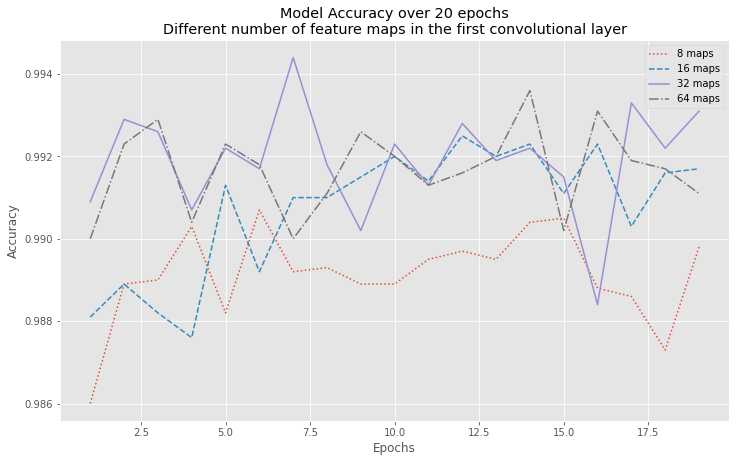

In [ ]:
linestyles = [':', '--', '-', '-.']
names = [f"{num_feature_maps} maps" for num_feature_maps in feature_maps]

plt.figure(figsize=(12,7))
x_axis = range(1, 20)
for i in range(4):
  plt.plot(x_axis, np.squeeze(all_test_accuracies[i][1:]), label=names[i], linestyle=linestyles[i])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over 20 epochs\nDifferent number of feature maps in the first convolutional layer')
plt.legend()
plt.savefig(f'{folder}/Acc_num_feature_maps_ep_20_Adam_lr_0.001_bs_32_act_Relu.png')

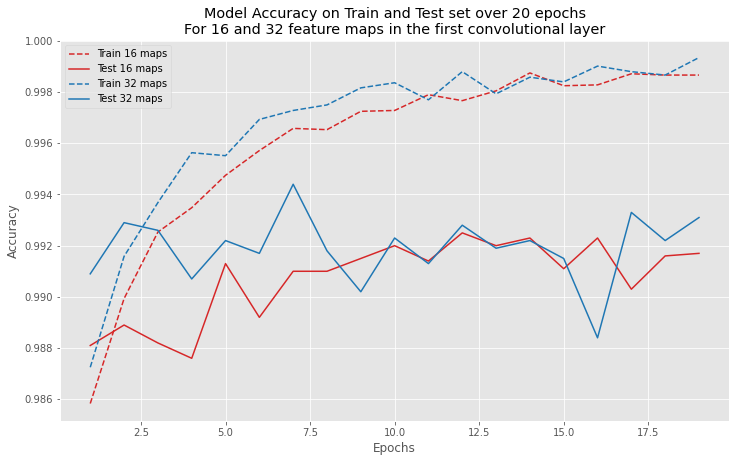

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(x_axis, np.squeeze(all_train_accuracies[1][1:]), "--", color="tab:red", label="Train " + names[1])
plt.plot(x_axis, np.squeeze(all_test_accuracies[1][1:]), color="tab:red", label="Test " + names[1])
plt.plot(x_axis, np.squeeze(all_train_accuracies[2][1:]), "--", color="tab:blue", label="Train " + names[2])
plt.plot(x_axis, np.squeeze(all_test_accuracies[2][1:]), color="tab:blue", label="Test " + names[2])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Train and Test set over 20 epochs\nFor 16 and 32 feature maps in the first convolutional layer')
plt.legend()
plt.savefig(f'{folder}/Acc_num_feature_maps_16-32_ep_20_Adam_lr_0.001_bs_32_act_Relu.png')

Conclusion: Model with 32 feature maps in the first convolutional layer performs better on test set and also less overfit.

CNN with 16 feature maps in the first convolutional layer
FINAL
  loss: 0.0041, acc: 0.9987
  test_loss: 0.0444, test_acc: 0.9917

CNN with 32 feature maps in the first convolutional layer
FINAL
  loss: 0.0023, acc: 0.9993
  test_loss: 0.0504, test_acc: 0.9931

#### 3. Change of activation function (ReLU vs Sigmoid vs Tanh)

In [ ]:
class CNN_act(nn.Module):
    def __init__(self, activation):
      super(CNN_act, self).__init__()

      if activation == "relu":
        self.activation = nn.ReLU()
      elif activation == "sigmoid":
        self.activation = nn.Sigmoid()
      elif activation == "tanh":
        self.activation = nn.Tanh()
            
      self.model = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
          self.activation,
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          self.activation,
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          self.activation
      )

      self.classifier = nn.Sequential(
          nn.Linear(128*7*7, 10) 
      )

    def forward(self, x):
      x = self.model(x)
      x = self.classifier(x.view(x.size(0), -1))
      return x

In [ ]:
models_act = []
all_train_losses, all_train_accuracies, all_test_losses, all_test_accuracies = [], [], [], []

activation_functions = ["relu", "sigmoid", "tanh"]
for act in activation_functions:
  print(f"\nCNN with {act} activation function")

  cnn = CNN_act(act).to(device)

  # Define loss and optimizer
  loss_criterion = nn.CrossEntropyLoss().to(device)
  optimizer = optim.Adam(cnn.parameters(), lr=0.001)

  train_losses, train_accuracies, test_losses, test_accuracies = train_model(fnn, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=20)
  all_train_losses.append(train_losses)
  all_train_accuracies.append(train_accuracies)
  all_test_losses.append(test_losses)
  all_test_accuracies.append(test_accuracies)
  models_act.append(cnn)


CNN with relu activation function
FINAL
  loss: 1.4682, acc: 0.9929
  test_loss: 1.4721, test_acc: 0.9892

CNN with sigmoid activation function
FINAL
  loss: 1.4744, acc: 0.9880
  test_loss: 1.4773, test_acc: 0.9852

CNN with tanh activation function
FINAL
  loss: 1.4682, acc: 0.9932
  test_loss: 1.4730, test_acc: 0.9881


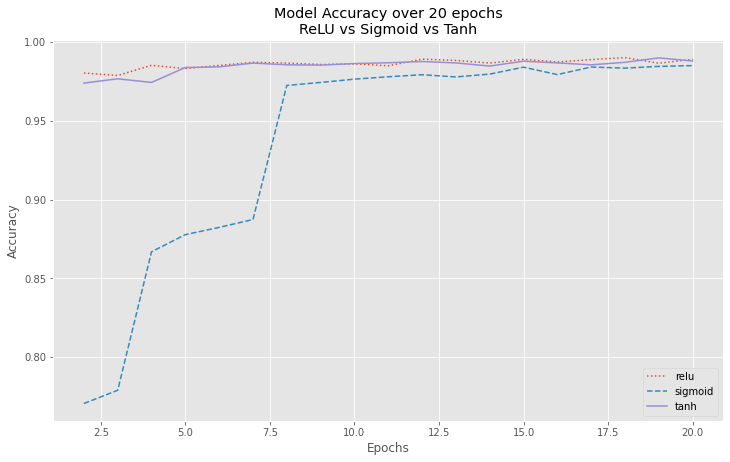

In [ ]:
colors = ["tab:red",  "tab:orange", "tab:blue"]
linestyles = [':', '--', '-', '-.']

plt.figure(figsize=(12,7))
for i in range(len(activation_functions)):
  plt.plot(x_axis, np.squeeze(all_test_accuracies[i][1:]), label=activation_functions[i], linestyle=linestyles[i])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over 20 epochs\nReLU vs Sigmoid vs Tanh')
plt.legend()
plt.savefig(f'{folder}/Acc_activation_ep_20_Adam_lr_0.001_bs_32.png')

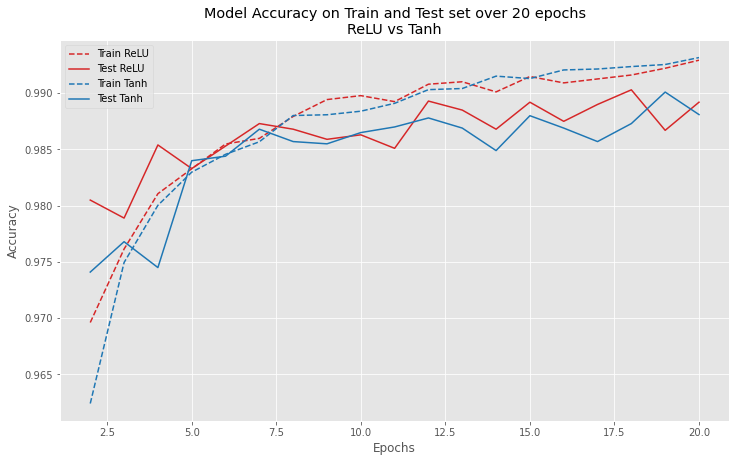

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(x_axis, np.squeeze(all_train_accuracies[0][1:]), "--", color="tab:red", label="Train ReLU")
plt.plot(x_axis, np.squeeze(all_test_accuracies[0][1:]), color="tab:red", label="Test ReLU")
plt.plot(x_axis, np.squeeze(all_train_accuracies[2][1:]), "--", color="tab:blue", label="Train Tanh")
plt.plot(x_axis, np.squeeze(all_test_accuracies[2][1:]), color="tab:blue", label="Test Tanh")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Train and Test set over 20 epochs\nReLU vs Tanh')
plt.legend()
plt.savefig(f'{folder}/Acc_ReLU_vs_Tanh_ep_20_Adam_lr_0.001_bs_32.png')

Conclusion: Faster convergence and better accuracy with Relu

#### 4. Dropout?
0%, 10%, 20%, 30%, 40%, 50%, or 60%?

In [ ]:
class CNN_dropout(nn.Module):
    def __init__(self, dropout):
      super(CNN_dropout, self).__init__()
      self.model = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout2d(p=dropout),
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout2d(p=dropout),
          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.ReLU() 
      )

      self.classifier = nn.Sequential(
          nn.Linear(128*7*7, 10)
      )

    def forward(self, x):
      x = self.model(x)
      x = self.classifier(x.view(x.size(0), -1))
      return x

In [ ]:
models_dropout = []
all_train_losses, all_train_accuracies, all_test_losses, all_test_accuracies = [], [], [], []

for i in range(7):
  print(f"\nCNN with {i * 0.1:.1f} dropout")

  cnn = CNN_dropout(i*0.1).to(device)

  # Define loss and optimizer
  loss_criterion = nn.CrossEntropyLoss().to(device)
  optimizer = optim.Adam(cnn.parameters(), lr=0.001)

  train_losses, train_accuracies, test_losses, test_accuracies = train_model(fnn, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=20)
  all_train_losses.append(train_losses)
  all_train_accuracies.append(train_accuracies)
  all_test_losses.append(test_losses)
  all_test_accuracies.append(test_accuracies)
  models_dropout.append(cnn)


CNN with 0.0 dropout
FINAL
  loss: 1.4695, acc: 0.9916
  test_loss: 1.4709, test_acc: 0.9905

CNN with 0.1 dropout
FINAL
  loss: 1.4753, acc: 0.9859
  test_loss: 1.4769, test_acc: 0.9841

CNN with 0.2 dropout
FINAL
  loss: 1.4788, acc: 0.9824
  test_loss: 1.4795, test_acc: 0.9817

CNN with 0.3 dropout
FINAL
  loss: 1.4862, acc: 0.9749
  test_loss: 1.4851, test_acc: 0.9762

CNN with 0.4 dropout
FINAL
  loss: 1.4936, acc: 0.9676
  test_loss: 1.4934, test_acc: 0.9679

CNN with 0.5 dropout
FINAL
  loss: 1.5034, acc: 0.9576
  test_loss: 1.5013, test_acc: 0.9594

CNN with 0.6 dropout
FINAL
  loss: 1.5806, acc: 0.8767
  test_loss: 1.5782, test_acc: 0.8789


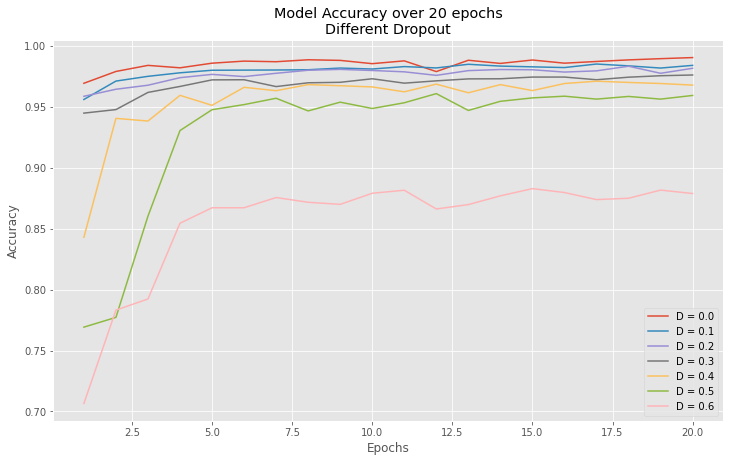

In [ ]:
plt.figure(figsize=(12,7))

for i in range(7):
  label = f"D = {i*0.1:.1f}"
  plt.plot(range(1, NUM_EPOCHS + 1), np.squeeze(all_test_accuracies[i]), label=label)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over 20 epochs\nDifferent Dropout')
plt.legend()
plt.savefig(f'{folder}/Acc_dropout_ep_20_lr_0.001_bs_32_act_Relu_Adam.png')

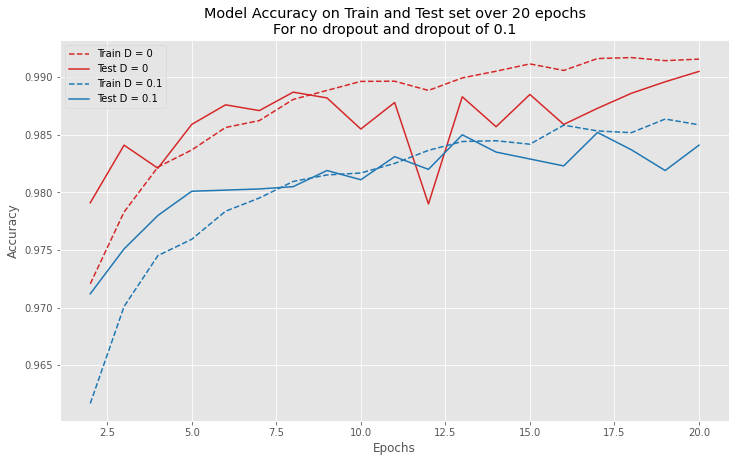

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(x_axis, np.squeeze(all_train_accuracies[0][1:]), "--", color="tab:red", label="Train D = 0")
plt.plot(x_axis, np.squeeze(all_test_accuracies[0][1:]), color="tab:red", label="Test D = 0")
plt.plot(x_axis, np.squeeze(all_train_accuracies[1][1:]), "--", color="tab:blue", label="Train D = 0.1")
plt.plot(x_axis, np.squeeze(all_test_accuracies[1][1:]), color="tab:blue", label="Test D = 0.1")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Train and Test set over 20 epochs\nFor no dropout and dropout of 0.1')
plt.legend()
plt.savefig(f'{folder}/Acc_dropout_0-0.1_ep_20_Adam_lr_0.001_bs_32_act_Relu.png')

Conclusion: Better accuracy with no dropout

#### 5. Batch Normalization

In [ ]:
class CNN_bn(nn.Module):
    def __init__(self):
      super(CNN_bn, self).__init__()
      self.model = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2), # output: 8x14x14
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2), # output: 16x7x7
          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU() 
      )

      self.classifier = nn.Sequential(
          nn.Linear(128*7*7, 10)
      )

    def forward(self, x):
      x = self.model(x)
      x = self.classifier(x.view(x.size(0), -1))
      return x

In [ ]:
cnn_bn = CNN_bn().to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(cnn_bn.parameters(), lr=0.001)

train_losses_bn, train_accuracies_bn, test_losses_bn, test_accuracies_bn = train_model(fnn, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=20)

FINAL
  loss: 1.4662, acc: 0.9950
  test_loss: 1.4688, test_acc: 0.9924


In [ ]:
train_accuracies_without_bn = all_train_accuracies[0]
test_accuracies_without_bn = all_test_accuracies[0]

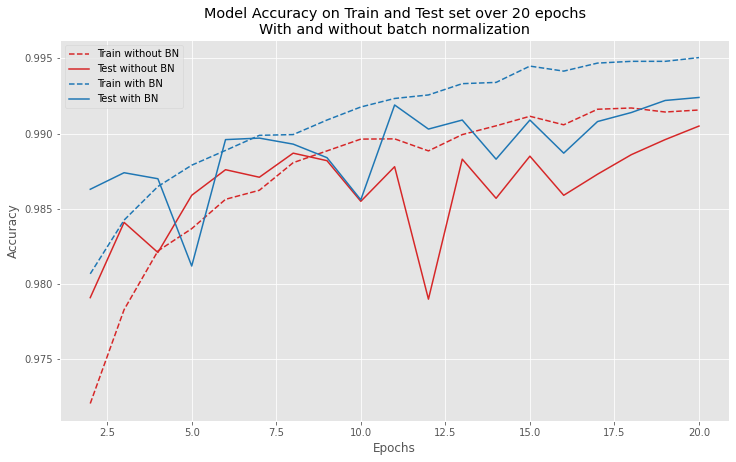

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(x_axis, np.squeeze(train_accuracies_without_bn[1:]), "--", color="tab:red", label="Train without BN")
plt.plot(x_axis, np.squeeze(test_accuracies_without_bn[1:]), color="tab:red", label="Test without BN")
plt.plot(x_axis, np.squeeze(train_accuracies_bn[1:]), "--", color="tab:blue", label="Train with BN")
plt.plot(x_axis, np.squeeze(test_accuracies_bn[1:]), color="tab:blue", label="Test with BN")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Train and Test set over 20 epochs\nWith and without batch normalization')
plt.legend()
plt.savefig(f'{folder}/Acc_BN_vs_without_ep_20_Adam_lr_0.001_bs_32_act_Relu.png')

Conclusion: Better accuracy with batch normalization

#### 6. L1 and L2 Regularization with SGD

In [ ]:
cnn_l1 = CNN_bn().to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(cnn_l1.parameters(), lr=0.1)

train_losses_l1, train_accuracies_l1, test_losses_l1, test_accuracies_l1 = train_model(cnn_l1, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=20, is_L1=True, plot_result=True)

Epoch [1/20]
  loss: 1.5188, acc: 0.9538
  test_loss: 1.4835, test_acc: 0.9818

Epoch [2/20]
  loss: 1.4816, acc: 0.9834
  test_loss: 1.4771, test_acc: 0.9866

Epoch [3/20]
  loss: 1.4772, acc: 0.9863
  test_loss: 1.4746, test_acc: 0.9885

Epoch [4/20]
  loss: 1.4743, acc: 0.9890
  test_loss: 1.4730, test_acc: 0.9901

Epoch [5/20]
  loss: 1.4723, acc: 0.9907
  test_loss: 1.4745, test_acc: 0.9886

Epoch [6/20]
  loss: 1.4711, acc: 0.9918
  test_loss: 1.4729, test_acc: 0.9901

Epoch [7/20]
  loss: 1.4705, acc: 0.9920
  test_loss: 1.4715, test_acc: 0.9910

Epoch [8/20]
  loss: 1.4695, acc: 0.9932
  test_loss: 1.4710, test_acc: 0.9915

Epoch [9/20]
  loss: 1.4691, acc: 0.9934
  test_loss: 1.4715, test_acc: 0.9908

Epoch [10/20]
  loss: 1.4682, acc: 0.9943
  test_loss: 1.4704, test_acc: 0.9917

Epoch [11/20]
  loss: 1.4679, acc: 0.9946
  test_loss: 1.4720, test_acc: 0.9897

Epoch [12/20]
  loss: 1.4673, acc: 0.9951
  test_loss: 1.4713, test_acc: 0.9909

Epoch [13/20]
  loss: 1.4666, acc: 0.

In [ ]:
cnn_l2 = CNN_bn().to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(cnn_l2.parameters(), lr=0.01, weight_decay=0.001)

train_losses_l2, train_accuracies_l2, test_losses_l2, test_accuracies_l2 = train_model(cnn_l2, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=20)

FINAL
  loss: 1.4838, acc: 0.9885
  test_loss: 1.4825, test_acc: 0.9885


In [ ]:
cnn_no_lreg = CNN_bn().to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(cnn_no_lreg.parameters(), lr=0.01)

train_losses_no_lreg, train_accuracies_no_lreg, test_losses_no_lreg, test_accuracies_no_lreg = train_model(cnn_no_lreg, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=20)

FINAL
  loss: 1.4743, acc: 0.9905
  test_loss: 1.4768, test_acc: 0.9870


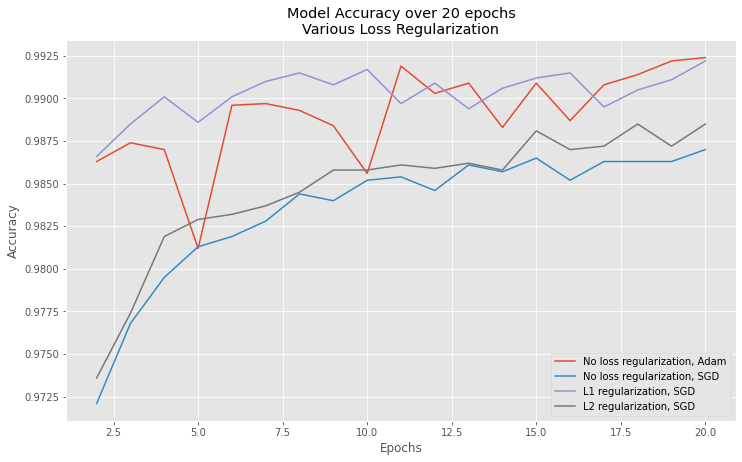

In [ ]:
plt.figure(figsize=(12,7))

plt.plot(x_axis, np.squeeze(test_accuracies_bn[1:]), label="No loss regularization, Adam")
plt.plot(x_axis, np.squeeze(test_accuracies_no_lreg[1:]), label="No loss regularization, SGD")
plt.plot(x_axis, np.squeeze(test_accuracies_l1[1:]), label="L1 regularization, SGD")
plt.plot(x_axis, np.squeeze(test_accuracies_l2[1:]), label="L2 regularization, SGD")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over 20 epochs\nVarious Loss Regularization')
plt.legend()
plt.savefig(f'{folder}/Acc_lreg_ep_20_bs_32_act_Relu.png')

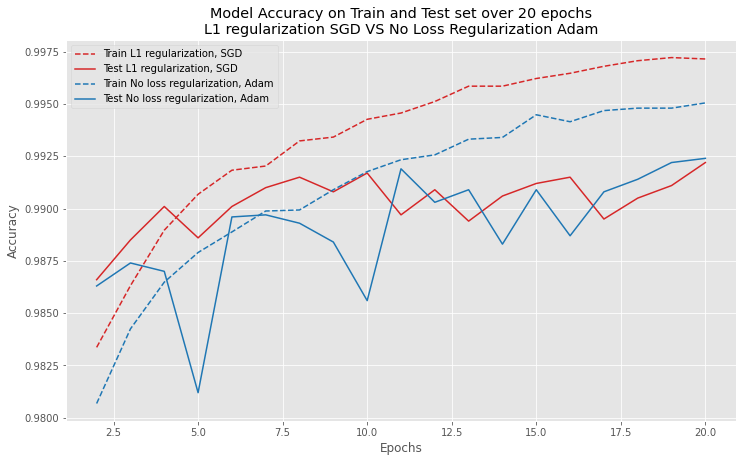

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(x_axis, np.squeeze(train_accuracies_l1[1:]), "--", color="tab:red", label="Train L1 regularization, SGD")
plt.plot(x_axis, np.squeeze(test_accuracies_l1[1:]), color="tab:red", label="Test L1 regularization, SGD")
plt.plot(x_axis, np.squeeze(train_accuracies_bn[1:]), "--", color="tab:blue", label="Train No loss regularization, Adam")
plt.plot(x_axis, np.squeeze(test_accuracies_bn[1:]), color="tab:blue", label="Test No loss regularization, Adam")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Train and Test set over 20 epochs\nL1 regularization SGD VS No Loss Regularization Adam')
plt.legend()
plt.savefig(f'{folder}/Acc_l1reg_noreg_ep_20_bs_32_act_Relu.png')

Conclusion: Using Batch Normalization and Adam optimizer lead to a better performance

#### 7. Data Augmentation
We will try to augment the data by rotating each image.
We first want to see the rotation's effect on some original images samples.

In [ ]:
def plot_digits(images, title, savefig_title=None):
  fig, axs = plt.subplots(1, 10, figsize=(12, 2))
  axs = axs.flatten()
  for img, ax in zip(images, axs):
      ax.imshow(img, cmap='gray')
  plt.suptitle(title)
  if savefig_title:
    fig.savefig(savefig_title)
  plt.show()

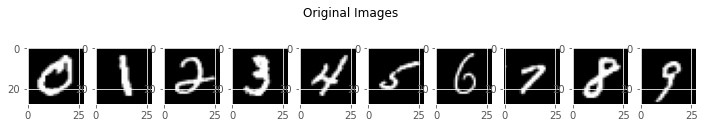

In [ ]:
imgs = [imageio.imread(f"MNIST/Train/{i}/0002.png") for i in range(10)]
plot_digits(imgs, title="Original Images", savefig_title=f"{folder}/original_images.png")

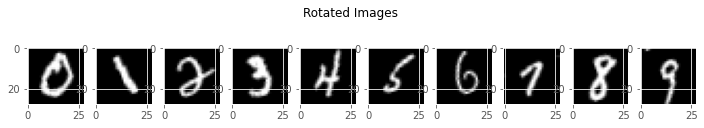

In [ ]:
imgs_rotated = [rotate(image, angle=20, mode = 'wrap') for image in imgs]
plot_digits(imgs_rotated, title="Rotated Images", savefig_title=f"{folder}/rotated_images.png")

##### Prepare the augmented dataset

We write a function to apply rotation to each image in the train set.

In [ ]:
def data_augment():
    NUM_LABELS = 10
    train_images = []
    train_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Train/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            train_images.append(image)
            train_labels.append(label)           
    
    train_images_augmented = [image for image in train_images]
    train_labels_augmented = [label for label in train_labels]

    for image, label in zip(train_images, train_labels):
      train_images_augmented.append(rotate(image, angle=20, mode = 'wrap'))
      train_labels_augmented.append(label)
    
    X_train_augmented = np.array(train_images_augmented)/255.0
    Y_train_augmented = np.array(train_labels_augmented)

    return X_train_augmented, Y_train_augmented

In [ ]:
X_train_augmented, Y_train_augmented = data_augment()

In [ ]:
print(X_train_augmented.shape, Y_train_augmented.shape)

(120000, 28, 28) (120000,)


In [ ]:
X_train_augmented = X_train_augmented.reshape(120000, 1, 28, 28)

# Training set
train_set_aug = MyMNISTDataset(X_train_augmented, Y_train_augmented)
train_loader_aug = DataLoader(train_set_aug, batch_size=BATCH_SIZE, shuffle=True)

##### Train the models
We chose to train the model with batch normalization because it is the best model until now.

In [ ]:
# Train the model on the regular dataset
cnn_bn = CNN_bn().to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(cnn_bn.parameters(), lr=0.001)

train_losses_bn, train_accuracies_bn, test_losses_bn, test_accuracies_bn = train_model(cnn_bn, loss_criterion, compute_accuracy, optimizer, train_loader, X_test, Y_test, num_epochs=20, plot_result=True)

Epoch [1/20]
  loss: 0.1093, acc: 0.9679
  test_loss: 0.0422, test_acc: 0.9876

Epoch [11/20]
  loss: 0.0087, acc: 0.9971
  test_loss: 0.0394, test_acc: 0.9883

FINAL
  loss: 0.0036, acc: 0.9987
  test_loss: 0.0449, test_acc: 0.9900


In [ ]:
# Train the model on the augmented dataset
cnn_bn_da = CNN_bn().to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(cnn_bn_da.parameters(), lr=0.001)

train_losses_bn_da, train_accuracies_bn_da, test_losses_bn_da, test_accuracies_bn_da = train_model(cnn_bn_da, loss_criterion, compute_accuracy, optimizer, train_loader_aug, X_test, Y_test, num_epochs=20, plot_result=True)

Epoch [1/20]
  loss: 1.1923, acc: 0.5526
  test_loss: 0.1857, test_acc: 0.9444

Epoch [11/20]
  loss: 0.0458, acc: 0.9858
  test_loss: 0.1887, test_acc: 0.9543

FINAL
  loss: 0.0286, acc: 0.9912
  test_loss: 0.1909, test_acc: 0.9612


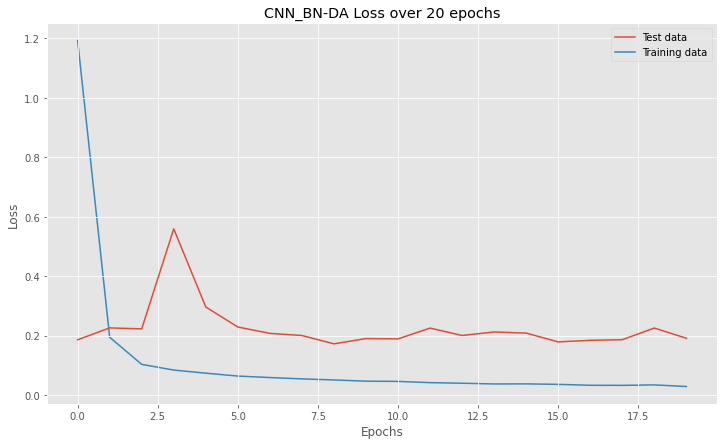

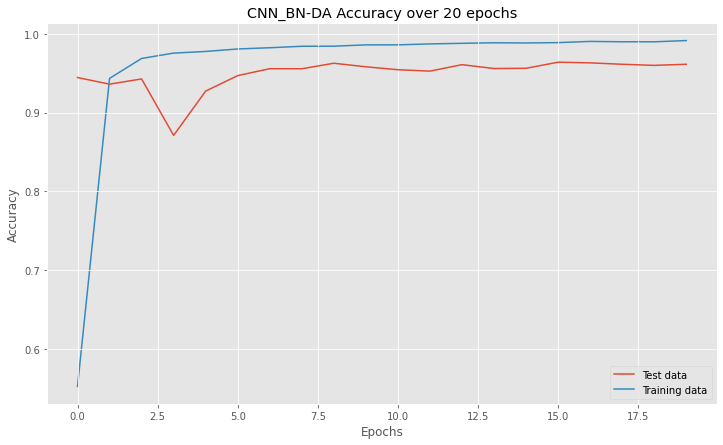

In [ ]:
model_name = "CNN_BN-DA"
plot_result("Loss", train_losses_bn_da, test_losses_bn_da, model_name, LEARNING_RATE, NUM_EPOCHS, save_folder=folder)
plot_result("Accuracy", train_accuracies_bn_da, test_accuracies_bn_da, model_name, LEARNING_RATE, NUM_EPOCHS, save_folder=folder)

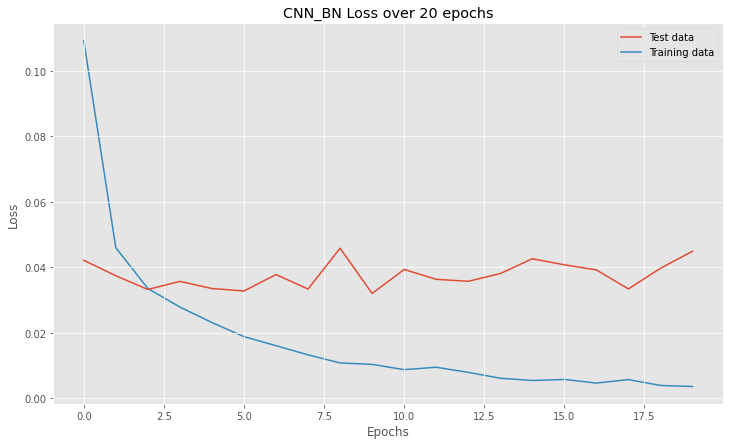

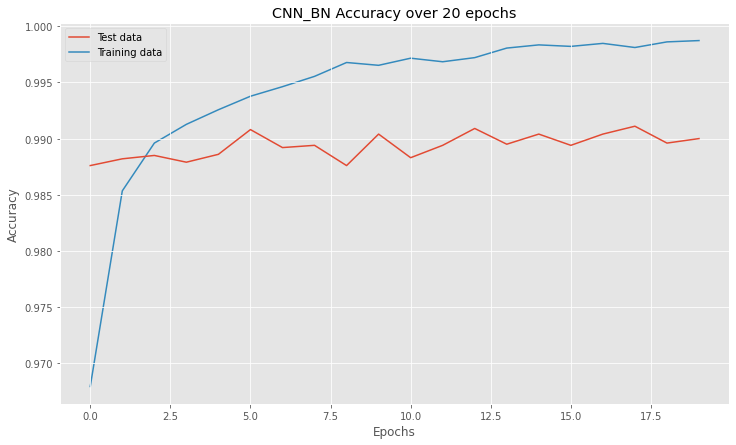

In [ ]:
model_name_bn = "CNN_BN"
plot_result("Loss", train_losses_bn, test_losses_bn, model_name_bn, LEARNING_RATE, NUM_EPOCHS, save_folder=folder)
plot_result("Accuracy", train_accuracies_bn, test_accuracies_bn, model_name_bn, LEARNING_RATE, NUM_EPOCHS, save_folder=folder)

Unexpectedly, we do not get a better performance with data augmentation.

### Best performing model
Our best performing model is the CNN with 3 convolution-activation-pool block, with 32 feature maps in the first convolution layer, ReLU as activation function, no dropout, with batch normalization, trained with Adam optimizer and a learning rate of 1e-3.

In [ ]:
# Save model 
model_name = "Best_CNN"
torch.save({
            'epoch': 20,
            'model_state_dict': cnn_bn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_losses_bn[-1],
            'acc': train_accuracies_bn[-1],
            'test_loss': test_losses_bn[-1],
            'test_acc': test_accuracies_bn[-1]
            }, f"{folder}/models/{model_name}")

In [ ]:
labels = [i for i in range(10)]
y_true = Y_test_numpy
predictions = cnn_bn(X_test)
y_pred = torch.argmax(predictions, dim=1).cpu()

conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

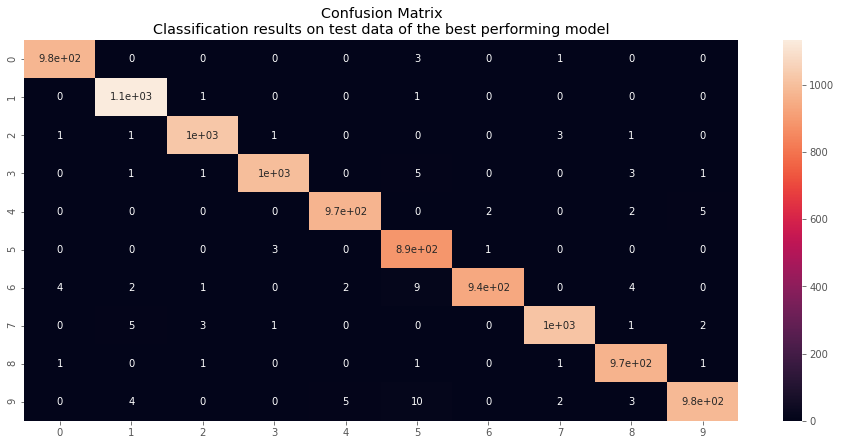

In [ ]:
import seaborn as sns

plt.figure(figsize = (16,7))
plt.title("Confusion Matrix\nClassification results on test data of the best performing model")
sns.heatmap(conf_matrix, annot=True)
plt.savefig(f"{folder}/conf_matrix.png")

In [ ]:
y_pred_np = y_pred.numpy()

In [ ]:
incorrects = np.where(y_pred_np != y_true)[0]
incorrects

array([  49,  270,  739,  782, 1192, 1290, 2650, 2695, 2755, 2776, 2940,
       2954, 3042, 3154, 3250, 3253, 3394, 3482, 3499, 3520, 3816, 3912,
       4083, 4106, 4263, 4356, 4569, 4578, 4675, 4899, 4901, 4978, 4981,
       5605, 5687, 5894, 5943, 6133, 6158, 6159, 6233, 6273, 6370, 6391,
       6405, 6414, 6527, 6548, 6551, 6639, 6677, 6689, 6734, 6760, 6822,
       6851, 6917, 6935, 6955, 7001, 7112, 7128, 7298, 7351, 7404, 7532,
       7562, 7705, 7747, 7825, 7869, 8175, 8277, 8356, 8642, 8816, 9057,
       9058, 9100, 9105, 9118, 9143, 9183, 9232, 9270, 9284, 9326, 9334,
       9444, 9478, 9504, 9505, 9634, 9647, 9708, 9725, 9783, 9814, 9882,
       9901])

In [ ]:
n = 3  # for 3 random indices
index = np.random.choice(incorrects.shape[0], n, replace=False) 
index = incorrects[index]
index

array([3520, 5894, 6370])

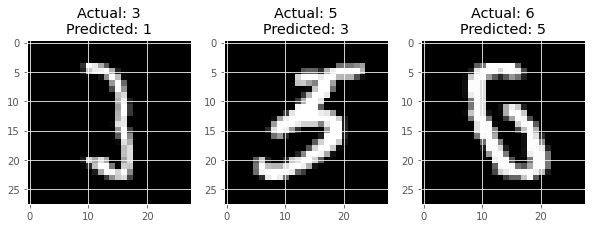

In [ ]:
images = X_test_numpy[index]
actual_labels = y_true[index]
predicted_labels = y_pred[index]

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs = axs.flatten()
for i, (img, ax) in enumerate(zip(images, axs)):
  ax.imshow(img[0], cmap='gray')
  ax.set_title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}")
plt.savefig(f"{folder}/missclassified_digits.png")
plt.show()